# Assignment 4

## Instructions
<ul>
    <li> Ensure that this assignment is your own work. PLagiarism will not be tolerated </li>
    <li> Ensure that all cells of this notebook run without error when run in order </li>
    <li> Follow the late day policy. Submit assignments on time </li>
    <li> Provide clear explanation for the algorithms you implement </li>
</ul>
Date released: 26/10/2020 

Due date: 01/11/2020 

Approximate time needed: 6-7 hours
    
## DLT and Epipolar Lines

The goal of this assignment is to aid your understanding of the Direct Linear Transform as well as Epipolar geometry.

For the first part of the assignment you will find correspondences between 2D-3D points and estimate the P Matrix. You will then be required to estimate Camera Parameters from this P matrix.

The second part of this assignment will require you to construct epipolar lines on two corresponding images.

---
## 4.1
### Generating Correspondences
The first step to perform DLT is to generate correspondences. The cell below opens a new window. Clicking anywhere on the image should give you the pixel location of the image. Once you're done clicking, close the image window. The cell after displays the points you have clicked.

In [1]:
%matplotlib tk
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np


image_points = [(412,673),(474,614),(520,573),(416,612),(425,539),(436,443),(340,388),(250,338),(173,292),(87,346),(162,391),(250,446),(351,503)]
fig = plt.figure(figsize=(20,30))

img=mpimg.imread('Images/dlt1.jpeg')

def onclick(event):
    ix, iy = event.xdata, event.ydata
    # print(ix, iy)
    image_points.append([ix, iy])

cid = fig.canvas.mpl_connect('button_press_event', onclick)

imgplot = plt.imshow(img)
plt.show()

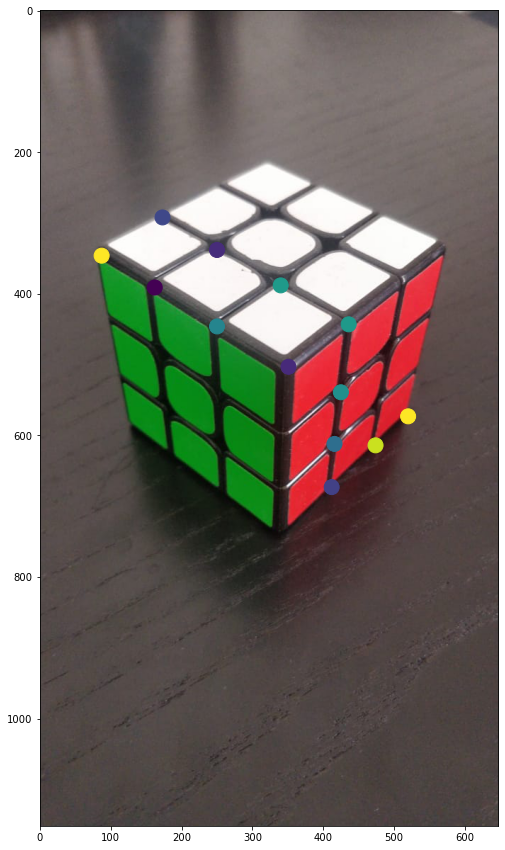

In [2]:
%matplotlib inline
N = len(image_points)
image_points = np.array(image_points)
fig = plt.figure(figsize=(10,15))

img=mpimg.imread('Images/dlt1.jpeg')
imgplot = plt.imshow(img)

colors = np.random.rand(N)
area = (15 * np.ones(N))**2 

plt.scatter(image_points[:,0], image_points[:,1], c=colors, s=area)
plt.show()

After generating pixel locations, you have to generate the corresponding world points. You have the freedom to chose which point you want as origin. You can consider each side as 4 units.

Ensure that the ordering of your points matches the ordering of image points. Keep track of the sequence of corners clicked.

In [3]:
#We'll rename image_points to x to match textbook convention
x = image_points
# X represents the 3D world points
world = [[4,0,0],[8,0,0],[12,0,0],[4,0,4],[4,0,8],[4,0,12],[4,4,12],[4,8,12],[4,12,12],[0,12,12],[0,8,12],[0,4,12],[0,0,12]]
#Add your points here
#Add them as 3D points only
# X.append([1,0,0])

X = np.array(world)

Now that we have the correspondences, we can estimate the P matrix. Implement the DLT function that returns the P matrix

Quick recap: x_i = P * X_i where (x_i, X_i) is the ith correspondence, and P is a 3x4 dimensional matrix. P is further decomposed as P = K * [ R | T].


In [4]:
#Helper functions
#appends a ones column to input
def hom_coords(x,X):
    n = x.shape[0]
    size = (n,1)
    ones = np.ones(size)
    x = np.concatenate(
        (x,ones),
        axis = 1)
    X = np.concatenate(
        (X,ones),
        axis = 1)
    return x, X

x,X = hom_coords(x,X)
print(x.shape,X.shape)

(13, 3) (13, 4)


#### Explanation

Direct linear transform (DLT) maps any object point to the image point.
$$
\textbf{x} = KR[I_{3}| - C]\textbf{X} = P \;\textbf{X}
$$
Where $P$ is the Projection matrix consisting of intrinsic parameters of camera given by $K$ and extrinsic parameters given by the rotations $R$ and translations $C$.$\newline$
To solve a linear equation of the form $x = P \;\textbf{X}$, we must see the number of unknowns. We have total 11 unknowns (homogeneity condition) for which atleast 6 points are needed so that they give us two observation equations each. Now, rearranging the equations and stacking the values we will obtain an equation of the form $M \;p = 0$. Optimally we solve such an equation by finding the non trivial elements of the null space of $M$. To find that, we apply Singular Value Decomposition.$\newline$
There could be cases where we have observations that are redundant, which give contradictions to $M\;p = 0$, leading to $M\;p = \omega$ for some $\omega$. In such a condition we find an estimate of $p$ such that it minimises the magnitude of $\omega$, thereby solving $p^{*} = \text{argmin}_{p}(p^{T}M^{T}Mp)$ with additional constraint of $||P||_{2} = 1$$\newline$
The SVD of $M$ gives:
$$
M = U \;S\; V^{T}
$$
If we choose the singular vector corresponding to smallest singular value which is non trivial, we will find $p$, which can be reshaped to obtain $P$.$\newline$
Once we obtain $P$, we can find $K,R,C$ as follows:
$$
P = [KR| -KRC] = [H|h] \newline
C = -H^{-1} h
$$
Once we get $H$, we can obtain $R^T$ and $K^{-1}$ by QR decomposition of $H^{-1}$. $K$ is triangular matrix and $R$ is Rotation matrix which is orthogonal.

In [5]:
#DLT function takes as input 
#the image points and world points
#return a 3x4 matrix
def DLT(x,X, normalise = False):
    """
    world is a variable containing n_world number of points and column vectors containing 3 numbers (x,y,z)
    image is a variable containing n_image number of points and column vectors containing 2 numbers (x,y)
    
    return P, R, K, C, C is translation, others follow the same notation.
    """
    world, image = X, x
    n_world = world.shape[0]
    n_image = image.shape[0]
    if (n_image != n_world):
        raise ValueError('Number of 2D image points and 3D image points are unequal.')
    if (n_world < 6):
        raise ValueError('Atleast 6 points needed.')
        
    if normalise is True:
        # normalisation to place mean at center and ensure mean distance is 1 in each direction
        mu, std = np.mean(world,0), np.std(world)
        #world_dash = normalised world pts
        world_dash = np.array([[std, 0, 0, mu[0]],[0, std, 0, mu[1]],[0, 0, std, mu[2]],[0, 0, 0, 1]])
        world_dash = np.linalg.inv(world_dash)
        world_copy = world.copy()
        #world_T = translation plus scaling for normalisation
        world_T = np.dot(world_dash, np.concatenate((world_copy.T, np.ones((1,world_copy.shape[0])))))
        world_T = world_T[0:3,:].T
    
        # normalisation to place mean at center and ensure mean distance is 1 in each direction
        mu, std = np.mean(image,0), np.std(image)
        #image_dash = normalised image pts
        image_dash = np.array([[std, 0, mu[0]],[0, std, mu[1]],[0, 0, 1]])
        image_dash = np.linalg.inv(image_dash)
        image_copy = image.copy()
        #image_T = translation plus scaling for normalisation
        image_T = np.dot(image_dash, np.concatenate((image_copy.T, np.ones((1,image_copy.shape[0])))))
        image_T = image_T[0:3,:].T
    
    A = []
    for i in range(n_world):
        if normalise is True:
            x, y, z = world_T[i,0], world_T[i,1], world_T[i,2]
            u, v = image_T[i,0], image_T[i,1]
        else:
            x, y, z = world[i,0], world[i,1], world[i,2]
            u, v = image[i,0], image[i,1]
        
        A.append([x, y, z, 1, 0, 0, 0, 0, -u*x, -u*y, -u*z, -u])
        A.append([0, 0, 0, 0, x, y, z, 1, -v*x, -v*y, -v*z, -v])
    A = np.asarray(A)
    u,s,v = np.linalg.svd(A)
    P = v[-1,:]/v[-1,-1]
    P = P.reshape(3,4)
    if normalise is True:
        p = np.dot(np.dot(np.linalg.pinv(image_dash), P), world_dash)
        p = p / p[-1,-1]
    else:
        p = P
        
    H_inf = p[:,0:3]
    h = -1*p[:,3]
    R, K = np.linalg.qr(H_inf)
    C = np.dot(np.linalg.pinv(H_inf),h)
    bp = np.dot(p, np.concatenate((world.T, np.ones((1,world.shape[0])))))
    bp=bp/bp[2,:]
    
    # Find MSE between reprojected points and x
    e = np.sqrt(np.mean(np.sum((bp[0:2,:].T-image)**2,1)))
    return p, R, K, C, e
#     P = np.random.randn(3,4)
#     return P

P, R, K, C, e = DLT(np.array(image_points),np.array(world))

## Analysing P

The next part of this question is to analyse how good our estimate is. Report the reprojection error of your P matrix

In [6]:
#Get reprojected points
def get_points(P,X):
    points = P@X.T
    points = points / points[2]
    points = points.T[:,0:2]
    return points

#Get reprojection error
def get_err(x, X, P):
    points = get_points(P, X)
    """
    find the MSE between reprojected points
    and x
    
    Not necessary as integrated in DLT Func.
    """
    #to err is to human
    #return err
    pass

Given the P matrix, we can estimate K, R and T. Write a function that returns K,R,T given P.
Note: 
P = K * [R | T] where K is a 3x3 matrix and [R | T], P are 3x4 matrices

In [7]:
def ret_RKT(P):
    """
    pass
    """
    pass
#     return R, K , T 

Reproject the world points with P matrix you have obtained via DLT:

Reconstruction error  =  3.2350243936181684


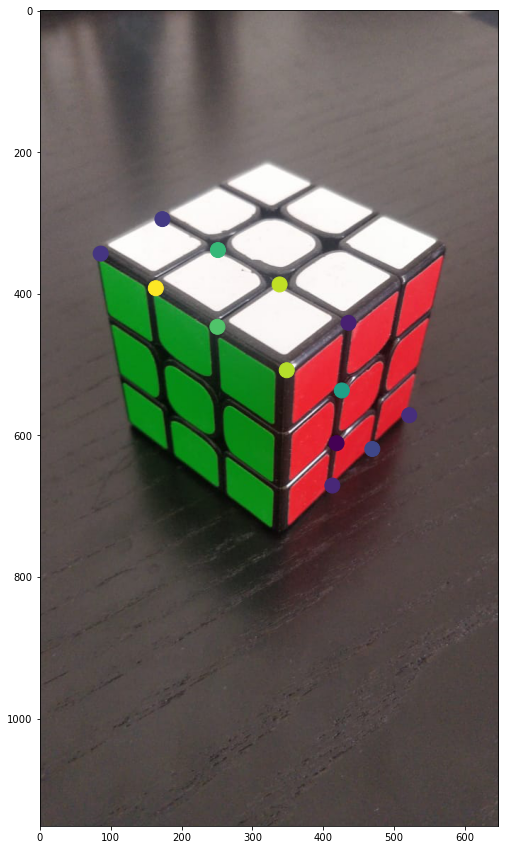

In [8]:
re_proj = get_points(P, X)
# print(re_proj.shape)
print('Reconstruction error  = ',e)

#code to plot these on the image
%matplotlib inline
N = len(re_proj)
re_proj = np.array(re_proj)
fig = plt.figure(figsize=(10,15))

img=mpimg.imread('Images/dlt1.jpeg')
imgplot = plt.imshow(img)

colors = np.random.rand(N)
area = (15 * np.ones(N))**2 

plt.scatter(re_proj[:,0], re_proj[:,1], c=colors, s=area)
plt.show()

### Zhangs method

For this task, use the inbuilt Opencv function to estimate the K matrix of a camera. Use the checkerboard images 5456-5470 in images/zhangs folder for this task. Familiarize yourself with the different parameters for this method.

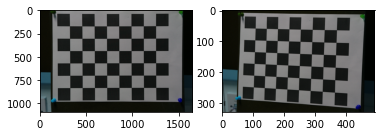

Reprojection Error: 0.6950125382616469
Camera Calibration Matrix:
[[4.09006559e+03 0.00000000e+00 9.92809120e+02]
 [0.00000000e+00 4.09681447e+03 4.49723994e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion Parameters:
[[ 9.65666696e-02  9.26407325e+00 -1.54132528e-02  2.67980297e-02
  -1.43793131e+02]]
Rotation Vectors for the images are:
[array([[-0.01085237],
       [-0.04668796],
       [-0.00307493]]), array([[-0.0063921 ],
       [ 0.22859937],
       [ 0.03520657]]), array([[-0.00956268],
       [-0.41406281],
       [-0.03565724]]), array([[ 0.01619591],
       [-0.61669467],
       [-0.07778576]]), array([[0.00528529],
       [0.31028188],
       [0.06531742]]), array([[-0.32573239],
       [-0.22023475],
       [-0.0169493 ]]), array([[-0.19318961],
       [-0.38313229],
       [-0.00386   ]]), array([[ 0.24482359],
       [-0.32052128],
       [ 0.02437994]]), array([[0.31042975],
       [0.06884667],
       [0.07006419]]), array([[ 0.34953259],
       [-0.561

In [9]:
#Code for zhangs here
import cv2
I1 = mpimg.imread('./Images/Zhangs/IMG_5456.JPG')
I2 = mpimg.imread('./Images/Zhangs/IMG_5457.JPG')
scale_percent = 30 # percent of original size
width = int(I1.shape[1] * scale_percent / 100)
height = int(I1.shape[0] * scale_percent / 100)
dim = (width, height)
I1 = cv2.resize(I1, dim, interpolation = cv2.INTER_AREA)
width = int(I1.shape[1] * scale_percent / 100)
height = int(I1.shape[0] * scale_percent / 100)
dim = (width, height)
I2 = cv2.resize(I2, dim, interpolation = cv2.INTER_AREA)
plt.subplot(121)
plt.imshow(I1[...,::-1])
plt.subplot(122)
plt.imshow(I2[...,::-1])
plt.show()
ret, corners = cv2.findChessboardCorners(I2
                                         ,(8,6)
#                                          ,flags=cv2.CALIB_CB_ADAPTIVE_THRESH+cv2.CALIB_CB_NORMALIZE_IMAGE
                                        )
corners = corners.reshape(-1,2)
x,y=np.meshgrid(range(8),range(6))
world_points=np.hstack((x.reshape(48,1),y.reshape(48,1),np.zeros((48,1)))).astype(np.float32)

_3d_points=[]
_2d_points=[]

for i in range(5456,5471):
    im=mpimg.imread('./Images/Zhangs/IMG_' + str(i) + '.JPG')
    scale_percent = 30 # percent of original size
    width = int(im.shape[1] * scale_percent / 100)
    height = int(im.shape[0] * scale_percent / 100)
    dim = (width, height)
    im = cv2.resize(im, dim, interpolation = cv2.INTER_AREA)
    ret, corners = cv2.findChessboardCorners(im, (8,6))
    
    if ret: #add points only if checkerboard was correctly detected:
        _2d_points.append(corners) #append current 2D points
        _3d_points.append(world_points) #3D points are always the same
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(_3d_points, _2d_points, (im.shape[1],im.shape[0]), None, None)

print('Reprojection Error:', ret)
print ('Camera Calibration Matrix:')
print(mtx)
print('Distortion Parameters:')
print(dist)
print('Rotation Vectors for the images are:')
print(rvecs)
print('Translation Vectors for the images are:')
print(tvecs)

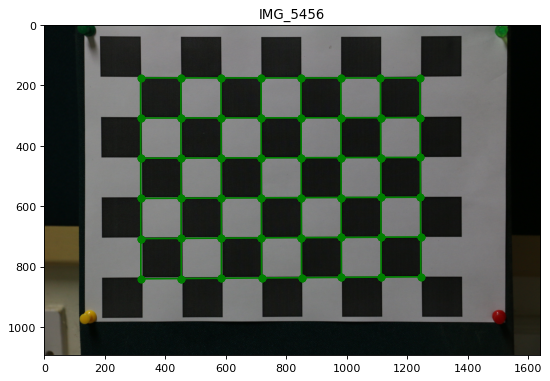

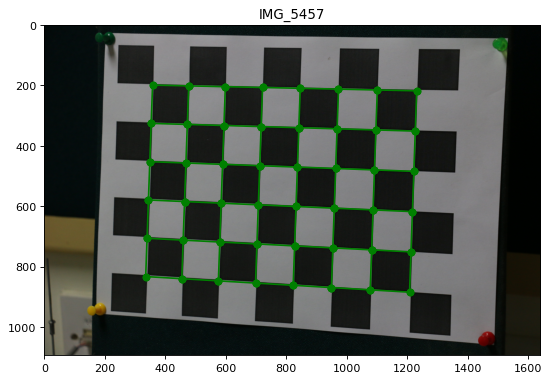

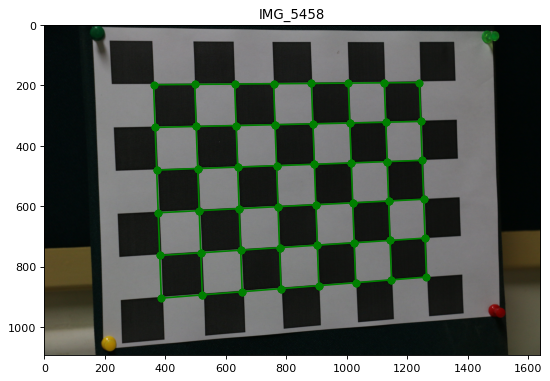

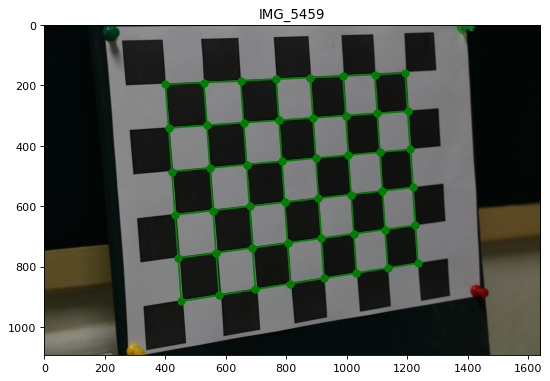

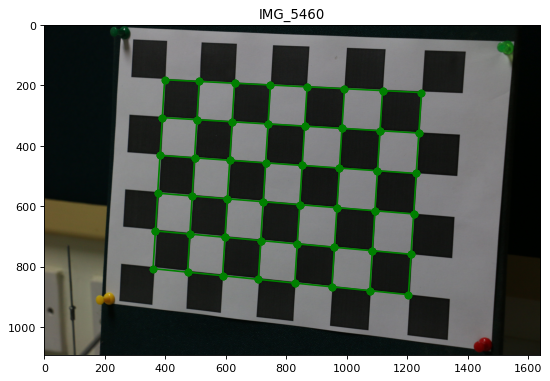

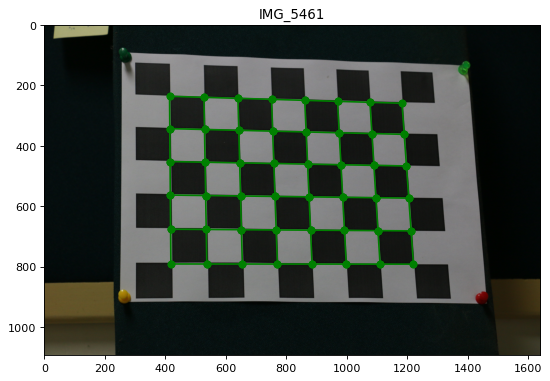

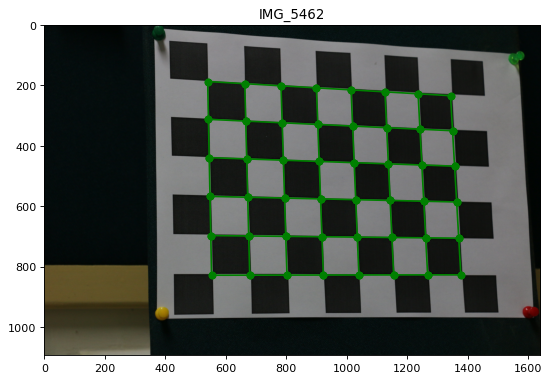

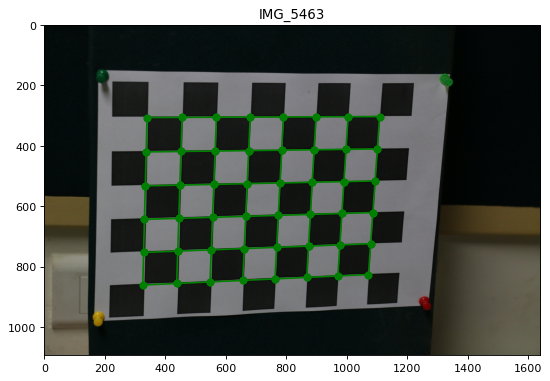

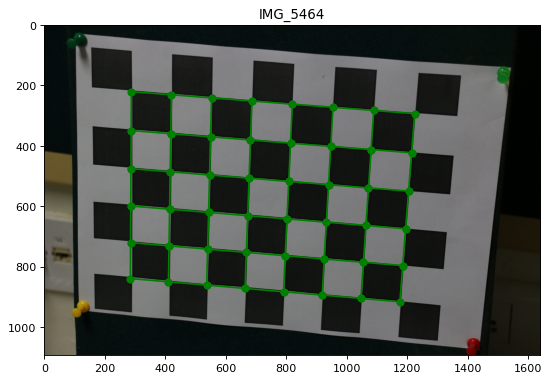

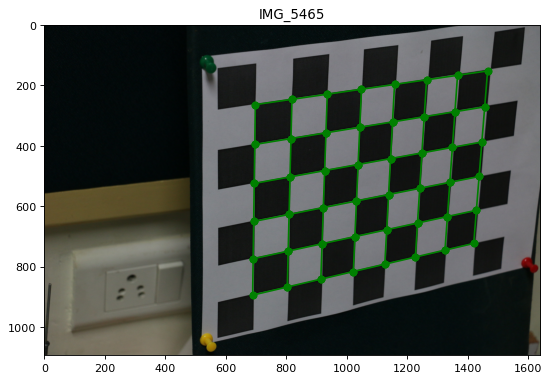

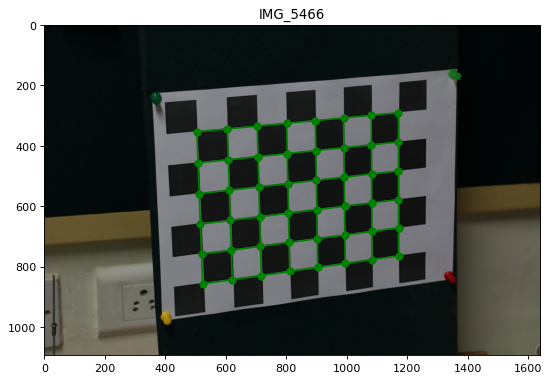

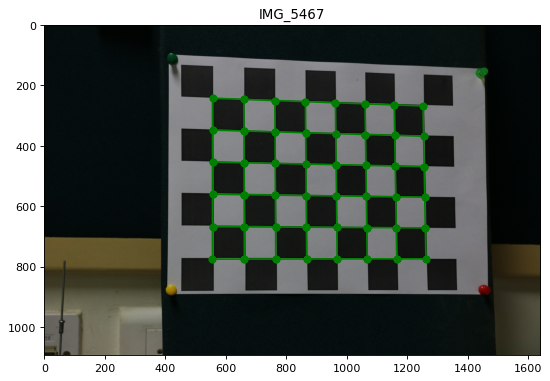

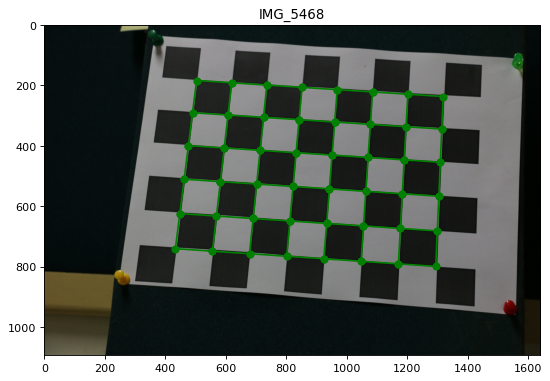

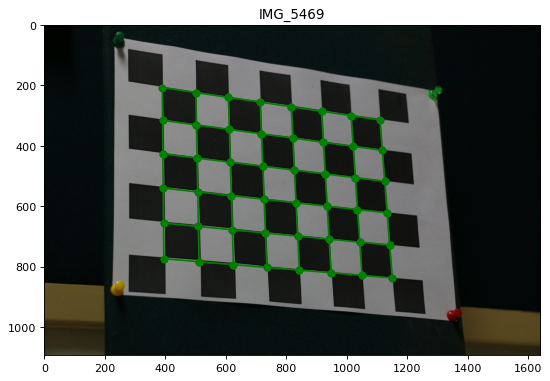

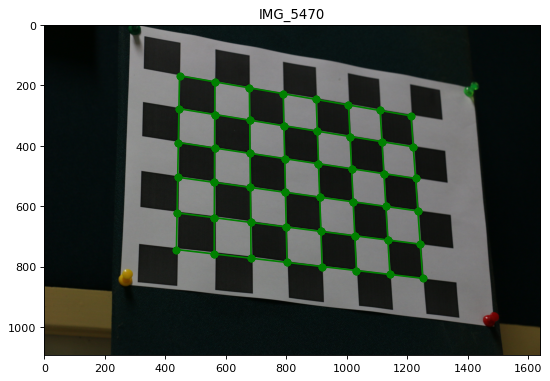

In [10]:
## Verification
for k in range(15):
    rotation_mat = np.zeros(shape=(3, 3))
    R = cv2.Rodrigues(rvecs[k], rotation_mat)[0]
    world_points_1 = np.hstack((x.reshape(48,1),y.reshape(48,1),np.zeros((48,1)),np.ones((48,1)))).astype(np.float32)

    temp1 = np.zeros((3,4))
    temp1[0:3,0:3] = R[0:3,0:3]
    temp1[:,3] = tvecs[k][:,0]
    P = np.matmul(mtx,temp1)
    P = P/P[2,3]

    projected_points = []
    for i in range(48):
        projection = np.matmul(P,np.transpose(world_points_1[i,:]))
        projection = projection/projection[2]
        projected_points.append(projection[0:2])
    projected_points = np.asarray(projected_points)
#     np.save('IMG_'+str(5456 + k)+'_resized',projected_points)
#     projected_points,_ = cv2.projectPoints(w_pts,rvecs[k],tvecs[k],mtx,None)
#     projected_points = projected_points[:,0,:]
    ### Wireframe
    idx = [7,15,23,31,39,47]
    q = 0
    p = 0
    fig = plt.figure(figsize=(8,8),dpi=80)
    for i in range(projected_points.shape[0]):
        if (i == idx[q]):
            q = q + 1
            continue
        plt.plot([projected_points[i][0],projected_points[i+1][0]],[projected_points[i][1],projected_points[i+1][1]],'go-')
    for i in range(8):
        i1 = i
        j =  i + 8
        while(j < 48):
            plt.plot([projected_points[i1][0],projected_points[j][0]],[projected_points[i1][1],projected_points[j][1]],'go-')
            i1 = j
            j = j + 8
    im = mpimg.imread('./Images/Zhangs/IMG_'+str(5456 + k)+'.JPG')
    scale_percent = 30 # percent of original size
    width = int(im.shape[1] * scale_percent / 100)
    height = int(im.shape[0] * scale_percent / 100)
    dim = (width, height)
    im = cv2.resize(im, dim, interpolation = cv2.INTER_AREA)
    plt.imshow(im)
    plt.title('IMG_'+str(5456 + k))
#     plt.savefig('IMG_'+str(5456 + k)+'_Wireframe.jpg')
    plt.show()

---
## 4.2
### Epipolar lines
#### Task 1

For this task, you have been given two images of the same scene taken from different view-points. The fundamental matrix that encodes their relative geometry as well as a subset of corresponding points have been provided to you. The images are in q2 folder.

Recall that given a point in one image, it's corresponding location in the other image can be found to along a line viz. the epipolar line. The task given to you is to draw the epipolar lines in the second image for each given point in the first image. You have to repeat this for the other image as well. Draw epipolar lines on the first image for the corresponding points in the second image.

The convention used for F is $x'^{T}Fx$ where $x'$ is the location of the point in the second image.

In [11]:
data_file = "q2/data.txt"

with open(data_file, 'r') as f:
    A = f.readlines()
    
img_points1 = A[2:12]
img_points1 = [i.strip()[:-1] for i in img_points1]
img_points1[0] = img_points1[0][1:]
img_points2 = A[15:25]
img_points2 = [i.strip()[:-1] for i in img_points2]
img_points2[0] = img_points2[0][1:]

F_mat = A[28:31]
F_mat = [i.strip()[:-1] for i in F_mat]
F_mat[0] = F_mat[0][1:]

img_1 = []
img_2 = []
F_MAT = []

for i in img_points1:
    img_1.append(np.fromstring(i[1:-1], sep=' '))
    
for i in img_points2:
    img_2.append(np.fromstring(i[1:-1], sep=' '))
    
for i in F_mat:
    F_MAT.append(np.fromstring(i[1:-1], sep=' '))

img_1,img_2 = hom_coords(np.array(img_1),np.array(img_2))
F_mat = np.array(F_MAT)

Provide a clear explanation on your approach for both this task and the next:

> Epilines for points in image1 ($x_1$) in image2 is given by $ F^Tx_1$$\newline$
> Epilines for points in image2 ($x_2$) in image2 is given by $ Fx_2$

We use OpenCV's line utility for this


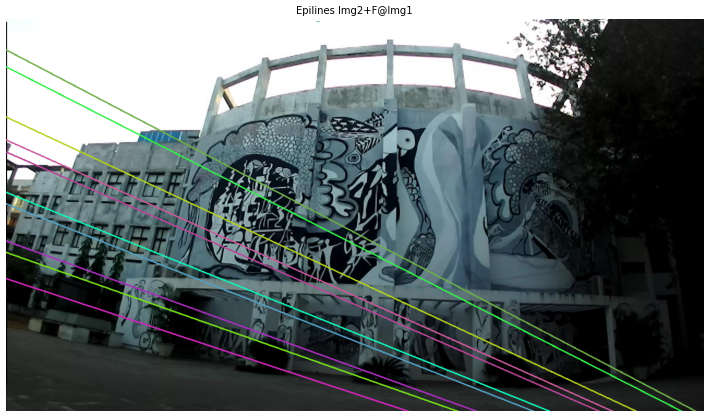

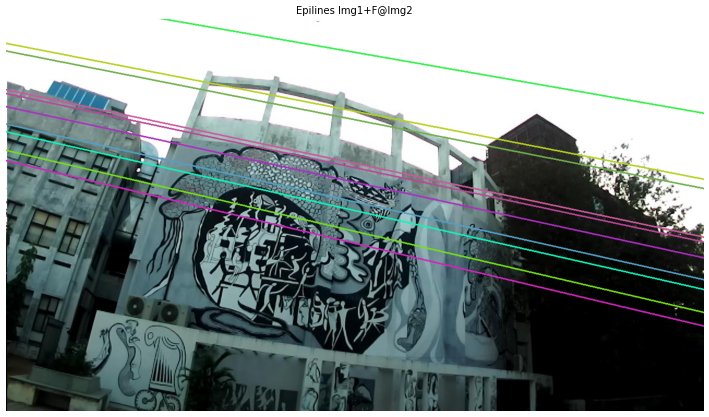

In [12]:
#Write code to plot epipolar lines on the images
def show_eplines(F, img_1, img_2, img1, img2):
    
    colors = []
    for i in range(max(img_1.shape[0],img_2.shape[0])):
        color = tuple(np.random.randint(0,255,3).tolist())
        colors.append(color)
        
    for i in range(img_1.shape[0]):
        line = F.T@img_1[i] # y = mx
        x0,y0 = map(int, [0, -line[2]/line[1]])
        x1,y1 = map(int, [img2.shape[1], -(line[2]+line[0]*img2.shape[1])/line[1]]) #y = mx + c
        img2 = cv2.line(img2, (x0,y0), (x1,y1), colors[i],2)
        
    for i in range(img_2.shape[0]):
        line = F@img_2[i]
        x0,y0 = map(int, [0, -line[2]/line[1]]) # y = mx
        x1,y1 = map(int, [img1.shape[1], -(line[2]+line[0]*img1.shape[1])/line[1]]) #y = mx + c
        img1 = cv2.line(img1, (x0,y0), (x1,y1), colors[i],2)
        
    plt.figure(figsize=(15,15),dpi=60)
    plt.title('Epilines Img2+F@Img1')
    plt.axis('off')
    plt.imshow(img2)
    plt.show()
    
    plt.figure(figsize=(15,15),dpi=60)
    plt.title('Epilines Img1+F@Img2')
    plt.axis('off')
    plt.imshow(img1)
    plt.show()

img1=cv2.cvtColor(cv2.imread('q2/img1.jpg'),cv2.COLOR_BGR2RGB)
img2=cv2.cvtColor(cv2.imread('q2/img2.jpg'),cv2.COLOR_BGR2RGB)
# print(F_mat.shape)
# print(img1.shape)
# print(img_1.shape)
show_eplines(F_mat, img_1, img_2, img1, img2)

# Write code to plot epipolar lines on the images

#### Task 2
Report the location of the epipoles.

The convergence point of the epilines is known as epipoles. For the given case they lie outside the frame of observation.